In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import Input, Conv1D, Conv1DTranspose, Flatten, Dense, Reshape, MaxPooling1D, BatchNormalization, Dropout

In [3]:
df = pd.read_csv('Data Fusion Assignment 2025 Data.csv')

In [4]:
df.head()

,class,id,color,transparency,device_id,spectrum_0 + 740,spectrum_1 + 740,spectrum_2 + 740,spectrum_3 + 740,spectrum_4 + 740,...,sample_raw_321 + 740,sample_raw_322 + 740,sample_raw_323 + 740,sample_raw_324 + 740,sample_raw_325 + 740,sample_raw_326 + 740,sample_raw_327 + 740,sample_raw_328 + 740,sample_raw_329 + 740,sample_raw_330 + 740
0,1,1,white,o,B0236F1F2D02C632,0.782157,0.754932,0.730555,0.709195,0.690707,...,5.54,5.32,5.08,4.80,4.50,4.16,3.80,3.42,3.00,2.55
1,1,2,white,o,B0236F1F2D02C632,0.948156,0.947904,0.947607,0.947237,0.946815,...,6.08,5.84,5.57,5.27,4.94,4.57,4.18,3.75,3.29,2.80
2,1,4,none,s,B0236F1F2D02C632,0.285657,0.285247,0.284841,0.284432,0.284022,...,1.47,1.42,1.35,1.28,1.20,1.11,1.01,0.91,0.80,0.68
3,1,5,none,s,B0236F1F2D02C632,0.296280,0.295966,0.295631,0.295269,0.294887,...,1.65,1.58,1.51,1.43,1.34,1.24,1.13,1.02,0.89,0.76
4,1,6,none,t,B0236F1F2D02C632,0.171568,0.171535,0.171500,0.171459,0.171414,...,1.31,1.26,1.20,1.14,1.07,0.99,0.90,0.81,0.71,0.61


In [5]:
df_without_class_8 = df[df['class'] != 8]
labels = df_without_class_8['class'].values

In [6]:
cat_df = df_without_class_8.loc[:,['transparency', 'color']]
cat_df.head()

,transparency,color
0,o,white
1,o,white
2,s,none
3,s,none
4,t,none


In [7]:
cat_df = pd.get_dummies(cat_df, drop_first=True).astype(int)
print(cat_df.shape)
cat_df.head()

(363, 11)


,transparency_s,transparency_t,color_blue,color_gray,color_green,color_none,color_orange,color_purple,color_red,color_white,color_yellow
0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,0
4,0,1,0,0,0,1,0,0,0,0,0


In [8]:
transparency_labels = cat_df.columns[cat_df.columns.str.startswith('transparency_')]
color_labels = cat_df.columns[cat_df.columns.str.startswith('color_')]

In [9]:
transparency_df = cat_df[transparency_labels]
color_df = cat_df[color_labels]

## Categorical embeddings

#### Transparency embeddings
Remember to create the folder called "weights". Also use GPU

In [10]:
transparency_train, transparency_test, y_transparency_train, y_transparency_test= train_test_split(transparency_df, labels, test_size=0.5, random_state=42)
print("Transparency Training Shape:", transparency_train.shape)

Transparency Training Shape: (181, 2)


In [11]:
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
      initial_learning_rate=initial_learning_rate,
      decay_steps=100000,
      decay_rate=0.96,
      staircase=True
  )

In [12]:
best_embedding_dim = 0
best_loss = float('inf')
best_autoencoder = None

for transparency_embedding_dim in range(1, 7):
    print(f"\nTraining with embedding dimension: {transparency_embedding_dim}")

    transparency_input = Input(shape=(transparency_train.shape[1],))
    transparency_encoded = Dense(transparency_embedding_dim, activation='relu',  kernel_initializer=HeNormal())(transparency_input)
    transparency_decoded = Dense(transparency_train.shape[1], activation='softmax')(transparency_encoded)

    transparency_autoencoder = Model(transparency_input, transparency_decoded)
    transparency_autoencoder.compile(optimizer=Adam(learning_rate=lr_schedule), loss='categorical_crossentropy')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = transparency_autoencoder.fit(
        transparency_train, transparency_train,
        validation_split=0.1,
        epochs=200, batch_size=32, verbose=0,
        callbacks=[early_stopping]
    )

    loss = min(history.history['loss'])
    val_loss = min(history.history['val_loss'])
    print(f"Training Loss achieved: {loss:.4f}, Validation Loss achieved: {val_loss:.4f}")


    if val_loss < best_loss:
      best_loss = val_loss
      best_embedding_dim = transparency_embedding_dim
      best_autoencoder = transparency_autoencoder

print(f"\nBest embedding dimension: {best_embedding_dim} with lowest validation loss: {best_loss:.4f}")


Training with embedding dimension: 1
Training Loss achieved: 0.2739, Validation Loss achieved: 0.2279

Training with embedding dimension: 2
Training Loss achieved: 0.0700, Validation Loss achieved: 0.0725

Training with embedding dimension: 3
Training Loss achieved: 0.0779, Validation Loss achieved: 0.0800

Training with embedding dimension: 4
Training Loss achieved: 0.0765, Validation Loss achieved: 0.0768

Training with embedding dimension: 5
Training Loss achieved: 0.0089, Validation Loss achieved: 0.0071

Training with embedding dimension: 6
Training Loss achieved: 0.0205, Validation Loss achieved: 0.0185

Best embedding dimension: 5 with lowest validation loss: 0.0071


In [13]:
weights_file_path = "best_transparency_autoencoder_weights.weights.h5"
best_autoencoder.save_weights(weights_file_path)

#### Color embedding

In [14]:
color_train, color_test, y_color_train, y_color_test = train_test_split(color_df, labels, test_size=0.5, random_state=42)
print("Color Training Shape:", color_train.shape)

Color Training Shape: (181, 9)


In [15]:
best_embedding_dim_color = 0
best_loss_color = float('inf')
best_autoencoder_color = None

for color_embedding_dim in range(1, 9):
    print(f"\nTraining with embedding dimension: {color_embedding_dim}")

    color_input = Input(shape=(color_train.shape[1],))
    color_encoded = Dense(color_embedding_dim, activation='relu',  kernel_initializer=HeNormal())(color_input)
    color_decoded = Dense(color_train.shape[1], activation='softmax')(color_encoded)

    color_autoencoder = Model(color_input, color_decoded)
    color_autoencoder.compile(optimizer=Adam(learning_rate=lr_schedule), loss='categorical_crossentropy')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = color_autoencoder.fit(
        color_train, color_train,
        validation_split=0.1,
        epochs=200, batch_size=32, verbose=0,
        callbacks=[early_stopping]
    )

    loss = min(history.history['loss'])
    val_loss = min(history.history['val_loss'])
    print(f"Training Loss achieved: {loss:.4f}, Validation Loss achieved: {val_loss:.4f}")


    if val_loss < best_loss_color:
        best_loss_color = val_loss
        best_embedding_dim_color = color_embedding_dim
        best_autoencoder_color = color_autoencoder

print(f"\nBest embedding dimension for color: {best_embedding_dim_color} with lowest validation loss: {best_loss_color:.4f}")


Training with embedding dimension: 1
Training Loss achieved: 1.1192, Validation Loss achieved: 0.8664

Training with embedding dimension: 2
Training Loss achieved: 0.6594, Validation Loss achieved: 0.4575

Training with embedding dimension: 3
Training Loss achieved: 0.6071, Validation Loss achieved: 0.4953

Training with embedding dimension: 4
Training Loss achieved: 0.4021, Validation Loss achieved: 0.3198

Training with embedding dimension: 5
Training Loss achieved: 0.4015, Validation Loss achieved: 0.1472

Training with embedding dimension: 6
Training Loss achieved: 0.3339, Validation Loss achieved: 0.1069

Training with embedding dimension: 7
Training Loss achieved: 0.1280, Validation Loss achieved: 0.0904

Training with embedding dimension: 8
Training Loss achieved: 0.1134, Validation Loss achieved: 0.1445

Best embedding dimension for color: 7 with lowest validation loss: 0.0904


In [16]:
weights_file_path = "best_color_autoencoder_weights.weights.h5"
best_autoencoder_color.save_weights(weights_file_path)

## Spectrum embedding

In [17]:
spectrum_columns = [col for col in df_without_class_8.columns if col.startswith('spectrum')]
spectrum_df = df_without_class_8[spectrum_columns]
spectrum_df.head()

,spectrum_0 + 740,spectrum_1 + 740,spectrum_2 + 740,spectrum_3 + 740,spectrum_4 + 740,spectrum_5 + 740,spectrum_6 + 740,spectrum_7 + 740,spectrum_8 + 740,spectrum_9 + 740,...,spectrum_321 + 740,spectrum_322 + 740,spectrum_323 + 740,spectrum_324 + 740,spectrum_325 + 740,spectrum_326 + 740,spectrum_327 + 740,spectrum_328 + 740,spectrum_329 + 740,spectrum_330 + 740
0,0.782157,0.754932,0.730555,0.709195,0.690707,0.674890,0.661358,0.649536,0.638722,0.628352,...,0.763257,0.763487,0.763256,0.762691,0.762037,0.761381,0.761238,0.761424,0.761624,0.761410
1,0.948156,0.947904,0.947607,0.947237,0.946815,0.946384,0.945992,0.945662,0.945352,0.945005,...,0.837685,0.838095,0.837967,0.837447,0.836808,0.836148,0.836038,0.836280,0.836527,0.836312
2,0.285657,0.285247,0.284841,0.284432,0.284022,0.283619,0.283231,0.282856,0.282474,0.282062,...,0.202998,0.203067,0.203011,0.202864,0.202691,0.202516,0.202477,0.202525,0.202576,0.202517
3,0.296280,0.295966,0.295631,0.295269,0.294887,0.294499,0.294121,0.293758,0.293394,0.293011,...,0.226905,0.227035,0.227019,0.226896,0.226739,0.226576,0.226560,0.226638,0.226717,0.226668
4,0.171568,0.171535,0.171500,0.171459,0.171414,0.171371,0.171338,0.171317,0.171298,0.171272,...,0.180999,0.181116,0.181115,0.181026,0.180908,0.180784,0.180777,0.180844,0.180909,0.180873


In [18]:
spectrum_train, spectrum_test, y_spectrum_train, y_spectrum_test= train_test_split(spectrum_df, labels, test_size=0.5, random_state=42)
print("Spectrum Training Shape:", spectrum_train.shape)

Spectrum Training Shape: (181, 331)


In [19]:
input_layer = Input(shape=(spectrum_train.shape[1], 1))

# autoencoder
x = Conv1D(32, 3, activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling1D(2, padding='same')(x)
x = Dropout(0.2)(x)

x = Conv1D(64, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(2, padding='same')(x)
x = Dropout(0.2)(x)

x = Conv1D(128, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(2, padding='same')(x)
x = Dropout(0.2)(x)

encoded = Flatten()(x)

# embedding
x = Dense(spectrum_train.shape[1] * 128, activation='relu')(encoded)
x = Reshape((spectrum_train.shape[1], 128))(x)

x = Conv1DTranspose(128, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv1DTranspose(64, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv1DTranspose(32, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

decoded = Conv1DTranspose(1, 3, activation='linear', padding='same')(x)

autoencoder = Model(input_layer, decoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')


In [20]:
autoencoder.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 331, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 331, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 331, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 166, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 166, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 166, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 166, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 83, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 83, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 83, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 83, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 42, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 42, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5376)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 42368)          │   227,812,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 331, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 331, 128)       │        49,280 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 331, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 331, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 331, 64)        │        24,640 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 331, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 227,925,761 (869.47 MB)

 Trainable params: 227,924,865 (869.46 MB)

 Non-trainable params: 896 (3.50 KB)

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

autoencoder.fit(
    spectrum_train.values, spectrum_train.values,
    validation_split=0.1,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

weights_file_path = "cnn_autoencoder_weights.weights.h5"
autoencoder.save_weights(weights_file_path)
print(f"CNN Autoencoder weights saved to {weights_file_path}")

Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 912ms/step - loss: 2.7860 - val_loss: 0.3977 - learning_rate: 0.0010
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 724ms/step - loss: 1.5146 - val_loss: 0.3262 - learning_rate: 0.0010
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 476ms/step - loss: 1.2317 - val_loss: 0.2768 - learning_rate: 0.0010
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 468ms/step - loss: 1.1196 - val_loss: 0.2352 - learning_rate: 0.0010
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 654ms/step - loss: 0.9256 - val_loss: 0.2045 - learning_rate: 0.0010
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 458ms/step - loss: 0.8104 - val_loss: 0.1899 - learning_rate: 0.0010
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 473ms/step - loss: 0.7660 - val_loss: 0.1645 - learning_rate: 0.0010
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 735ms/step - loss: 0.6646 - val_loss: 0.1567 - learning_rate: 0.0010
Epoch 9/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 456ms/step - loss: 0.6288 - val_loss: 0.1406 - learning_rate: 0.0010
Epoch 10/200
6/6 ━━

## Using the embeddings

In [27]:
# run this code if the code below doesn't work
transparency_input = Input(shape=(transparency_train.shape[1],))
transparency_encoded = Dense(transparency_embedding_dim, activation='relu',  kernel_initializer=HeNormal())(transparency_input)
transparency_decoded = Dense(transparency_train.shape[1], activation='softmax')(transparency_encoded)

best_autoencoder = Model(transparency_input, transparency_decoded)
best_autoencoder.compile(optimizer=Adam(learning_rate=lr_schedule), loss='categorical_crossentropy')

In [28]:
best_autoencoder.load_weights("embedding_weights/best_transparency_autoencoder_weights.weights.h5")# adjust path if needed

transparency_encoder = Model(
    inputs=best_autoencoder.input,
    outputs=best_autoencoder.layers[1].output
)

# get the embedding for the trianing/test data
trans_embeddings = transparency_encoder.predict(transparency_train)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/Users/sarahsuleman/Documents/DataFusion/DF_Project/tf-env/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1 variables whereas the saved optimizer has 9 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# same here
# color_input = Input(shape=(color_train.shape[1],))
# color_encoded = Dense(color_embedding_dim, activation='relu',  kernel_initializer=HeNormal())(color_input)
# color_decoded = Dense(color_train.shape[1], activation='softmax')(color_encoded)

# best_autoencoder_color = Model(color_input, color_decoded)
# best_autoencoder_color.compile(optimizer=Adam(learning_rate=lr_schedule), loss='categorical_crossentropy')

In [29]:
best_autoencoder_color.load_weights("embedding_weights/best_color_autoencoder_weights.weights.h5")# adjust path if needed

color_encoder = Model(
    inputs=best_autoencoder_color.input,
    outputs=best_autoencoder_color.layers[1].output
)

# get the embedding for the trianing/test data
color_embeddings = color_encoder.predict(color_train)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [30]:
#for this one you can run the code with model compilation - evertyhing should work after that
autoencoder.load_weights("embedding_weights/cnn_autoencoder_weights.weights.h5")# adjust path if needed

encoder = Model(
    inputs=autoencoder.input,
    outputs=autoencoder.get_layer(index=-6).output
)

# get the embedding for the trianing/test data
spectrum_embeddings = encoder.predict(spectrum_train)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


Explained variance ratio for first 5 components: [9.72268014e-01 1.74709738e-02 7.45398636e-03 2.15157625e-03
 3.60950072e-04]


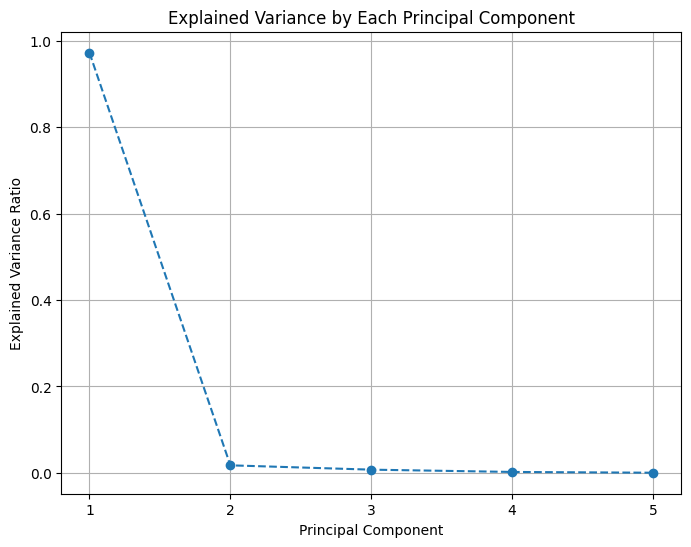

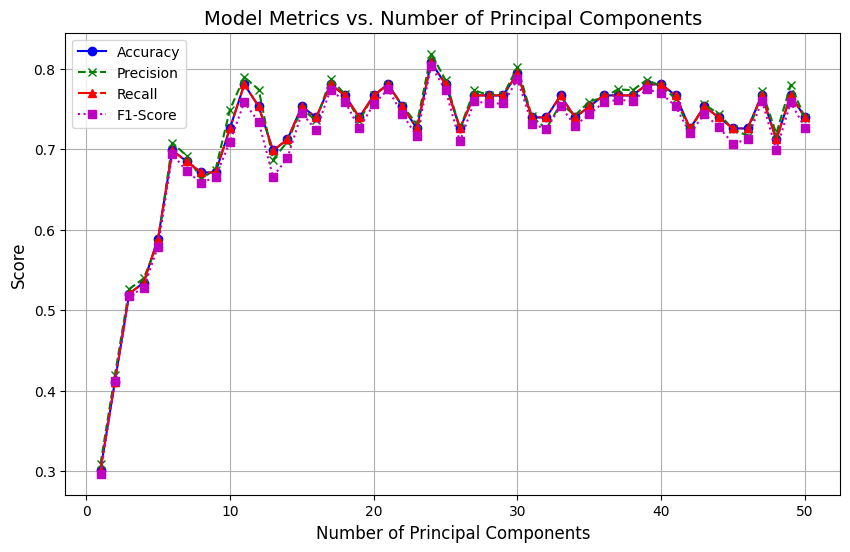

Best Random Forest Model found with 24 components
Best Accuracy: 80.82%
Random Forest Model for 24 Components
Number of Trees: 100

Top Features based on Importance:
   Feature  Importance
7      PC8    0.086180
12    PC13    0.084451
11    PC12    0.061813
16    PC17    0.061518
14    PC15    0.047621

Confusion Matrix:
[[11  1  0  0  2  0  1]
 [ 3  9  0  0  0  3  0]
 [ 0  0  9  1  0  0  0]
 [ 0  0  1  4  0  0  0]
 [ 0  0  0  0 12  0  1]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  1  0  2]]


In [38]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Read the dataset
df = pd.read_csv('Data Fusion Assignment 2025 Data.csv')

# Filter out rows where 'class' is 8
df_filtered = df[df['class'] != 8]

# Define columns to include
add_columns = ["class", "color", "transparency"]
selected_columns = [col for col in df_filtered.columns if col.startswith("spectrum_")] + add_columns
spectrum_df = df_filtered[selected_columns]
spectrum_df.head()

# Define a function to change column names
def change_column_name(column_names):
    updated_column_names = []
    for title in column_names:
        if title.startswith('spectrum') or title.startswith('wr_raw') or title.startswith('sample_raw'):
            updated_title = title.replace(' + 740', '')
            updated_column_names.append(updated_title)
        else:
            updated_column_names.append(title)
    return updated_column_names

# Update column names
spectrum_df.columns = change_column_name(spectrum_df.columns)
spectrum_df.head()

# Copy and drop unnecessary columns
copy_df = spectrum_df.copy(deep=True)
sp_df = copy_df.drop(['color', 'transparency', 'class'], axis=1)
sp_df.head()

# PCA transformation
pca = PCA()
pca_components = pca.fit_transform(sp_df)
pca_df = pd.DataFrame(pca_components, columns=[f'PC{i+1}' for i in range(pca_components.shape[1])])

print("Explained variance ratio for first 5 components:", pca.explained_variance_ratio_[:5])

plt.figure(figsize=(8, 6))
plt.plot(range(1, 6), pca.explained_variance_ratio_[:5], marker='o', linestyle='--')
plt.title('Explained Variance by Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, 6))
plt.grid(True)
plt.show()

# Concatenate PCA components with class labels and dummy variables for 'color' and 'transparency'
selected_columns = spectrum_df[['class', 'color', 'transparency']]
concat = pd.concat([pca_df, selected_columns], axis=1)
color_transparency_dummies = pd.get_dummies(concat[['color', 'transparency']])
concat = pd.concat([concat.drop(['color', 'transparency'], axis=1), color_transparency_dummies], axis=1)
concat.head()

# Variables to store the best model and its corresponding accuracy
best_accuracy = 0
best_rf_model = None
best_n_components = 0
best_rf_predictions = None

# Variables to track accuracy, precision, recall, and F1 scores for plotting
rf_accuracies = []
rf_precisions = []
rf_recalls = []
rf_f1_scores = []

# Loop over different numbers of principal components
for n_components in range(1, 51):
    X = concat.iloc[:, :n_components]
    y = concat['class']
    
    # Split the data, keeping only classes 1 to 7 (class 8 is excluded)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_test)

    # Calculate accuracy for the current model
    rf_accuracy = accuracy_score(y_test, rf_predictions)
    rf_accuracies.append(rf_accuracy)

    # Update best model if the current one has higher accuracy
    if rf_accuracy > best_accuracy:
        best_accuracy = rf_accuracy
        best_rf_model = rf_model
        best_n_components = n_components
        best_rf_predictions = rf_predictions

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, rf_predictions, average='weighted')

    rf_precisions.append(precision)
    rf_recalls.append(recall)
    rf_f1_scores.append(f1)

# Plotting the results
plt.figure(figsize=(10, 6))

plt.plot(range(1, 51), rf_accuracies, label='Accuracy', marker='o', linestyle='-', color='b')
plt.plot(range(1, 51), rf_precisions, label='Precision', marker='x', linestyle='--', color='g')
plt.plot(range(1, 51), rf_recalls, label='Recall', marker='^', linestyle='-.', color='r')
plt.plot(range(1, 51), rf_f1_scores, label='F1-Score', marker='s', linestyle=':', color='m')

plt.title('Model Metrics vs. Number of Principal Components', fontsize=14)
plt.xlabel('Number of Principal Components', fontsize=12)
plt.ylabel('Score', fontsize=12)

plt.legend()
plt.grid(True)
plt.show()

# Output the best model and its accuracy
print(f"Best Random Forest Model found with {best_n_components} components")
print(f"Best Accuracy: {best_accuracy * 100:.2f}%")

# Additional details for the best model
if best_rf_model is not None:
    print(f"Random Forest Model for {best_n_components} Components")
    print(f"Number of Trees: {len(best_rf_model.estimators_)}")

    # Feature Importances for the best model
    importances = best_rf_model.feature_importances_
    importance_df = pd.DataFrame({'Feature': [f'PC{i+1}' for i in range(best_n_components)], 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print("\nTop Features based on Importance:")
    print(importance_df.head())

    # Confusion Matrix for best model
    cm_rf = confusion_matrix(y_test, best_rf_predictions)
    print("\nConfusion Matrix:")
    print(cm_rf)


+---+------------------------------+---------------------+--------------------+---------------------+
|   |            Model             |      Accuracy       |     Precision      |       Recall        |
+---+------------------------------+---------------------+--------------------+---------------------+
| 0 |    Gradient Boosting (GB)    | 0.5405405405405406  | 0.5765765765765766 | 0.5405405405405406  |
| 1 |      Random Forest (RF)      | 0.43243243243243246 | 0.5294401544401545 | 0.43243243243243246 |
| 2 | Bayesian Consensus (GB + RF) | 0.5675675675675675  | 0.6801801801801802 | 0.5675675675675675  |
+---+------------------------------+---------------------+--------------------+---------------------+


/var/folders/my/y85t9bq97r5c14mjm7r8ncbm0000gp/T/ipykernel_92707/2071456595.py:182: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Metric", y="Score", hue="Model", data=df_melted,


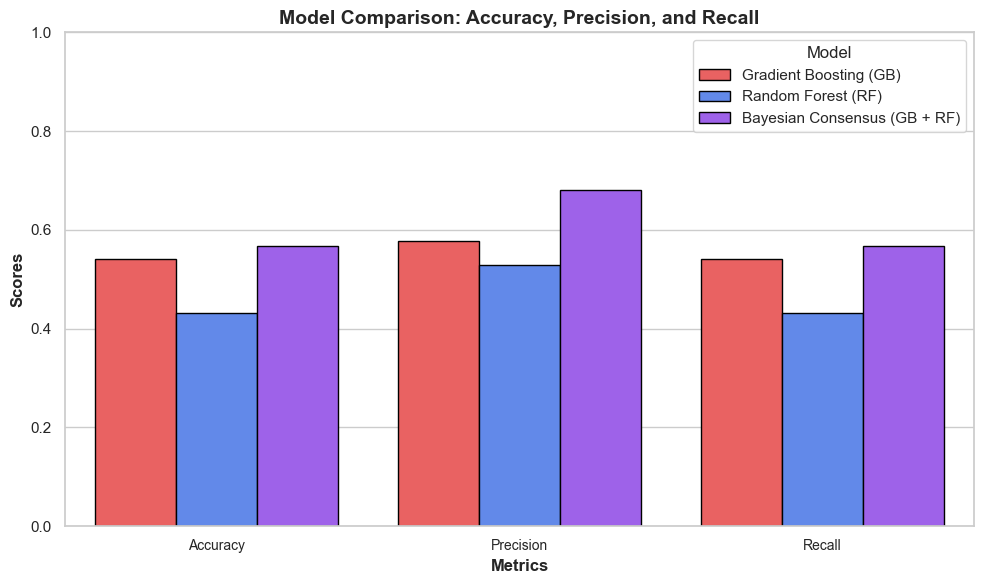

In [ ]:
#Imports
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

#SERIAL HIGH-LEVEL DATA FUSION - GRADIENT BOOSTING

#Reshape Spectral Embeddings to allow for concatenation
spectrum_embeddings_reshaped = spectrum_embeddings.reshape(spectrum_embeddings.shape[0], -1)

#Concatenate Transparency, Colour, and Spectral Data Horizontally
combined_embeddings = np.concatenate((trans_embeddings, spectrum_embeddings_reshaped, color_embeddings), axis = 1)

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_embeddings, y_transparency_train, test_size=0.2, random_state=42)

#Initialize Gradient Boosting Classifier
gradient_boost = GradientBoostingClassifier(n_estimators=1000, 
                                            warm_start=False,
                                            learning_rate=0.1,
                                            n_iter_no_change=10,
                                            random_state=42)

#Train the Gradient Boosting Model
gradient_boost.fit(X_train, y_train)

#Predict on the Test Set
y_test_pred_gb = gradient_boost.predict(X_test)

#Compute Accuracy on the Testing Set
gb_test_accuracy = accuracy_score(y_test, y_test_pred_gb)
gb_precision, gb_recall, gb_f1, _ = precision_recall_fscore_support(y_test, y_test_pred_gb, average='weighted')



#RANDOM FORREST CLASSIFIER 

#Initialize Gradient Boosting Classifier
rf = RandomForestClassifier(n_estimators=100, max_depth = 10, random_state=42)

#Train the Gradient Boosting Model
rf.fit(X_train, y_train)

#Predict on the Test Set
y_test_pred_rf = rf.predict(X_test)

#Compute Accuracy on the Testing Set
rf_test_accuracy = accuracy_score(y_test, y_test_pred_rf)
rf_precision, rf_recall, rf_f1, _ = precision_recall_fscore_support(y_test, y_test_pred_rf, average='weighted')



#SERIAL HIGH-LEVEL DATA FUSION - BAYESIAN CONSENSUS

def bayesian_consensus(confusion_matrices, y_test_pred, rf_predictions):

    likelihood_cm= []
    for cm in confusion_matrices:

        #Convert Confusion Matrices to Likelihood Estimates (Taken from chatgpt)
        cm_sum_per_class = cm.sum(axis=1, keepdims=True)  # Sum per class (rows)
        likelihood = cm / cm_sum_per_class  # Normalize each row to sum to 1
        likelihood_cm.append(likelihood)

    bay_predictions = []
    len_of_predictions = len(y_test_pred)

    #For all predictions 
    for j in range(len_of_predictions):

        e = y_test_pred[j] 

        #Initialize Prior Probabilities to have equal probability of occurring (p_hg for classes [1,2,3,4,5,6,7])
        p_hg = [1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7]

        #Initialize posterior probabilities 
        p = [0,0,0,0,0,0,0]

        #For each model 
        for m in likelihood_cm:

            for i in range(1,8):

                # p(h_g|e) = p(e|h_g) * p(h_g)/ sum_g(p(e|h_g) * p(h_g)) - Calculate Probability that True Value is Class x given the Prediction is Class y -> Becomes New Posterior Probability for Class x

                # p(e|h_g) * p(h_g)
                numerator = m[i-1, e-1]*p_hg[i-1]

                # sum_g (p(e|h_g) * p(h_g))
                denominator = np.sum([
                    m[0, e-1]*p_hg[0], 
                    m[1, e-1]*p_hg[1], 
                    m[2, e-1]*p_hg[2], 
                    m[3, e-1]*p_hg[3], 
                    m[4, e-1]*p_hg[4],
                    m[5, e-1]*p_hg[5], 
                    m[6, e-1]*p_hg[6]])
            
                #Collect Posterior Probabilities
                p[i-1] = numerator/denominator

                #Make next iterations prior probabilities the posterior probabilites from the previous iteration
                p_hg[i-1] = p[i-1]

            e = rf_predictions[j]

        bay_predictions.append(np.argmax(p)+ 1)
    
    return bay_predictions

#Compute Confusion Matrix For Gradient Boost Model
cm_gb = confusion_matrix(y_test, y_test_pred_gb)
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
confusion_matrices = [cm_gb, cm_rf]
px = bayesian_consensus(confusion_matrices, y_test_pred_gb, y_test_pred_rf)

# Calculate the number of correct predictions
correct_matches = sum([1 for true, predicted in zip(y_test, px) if true == predicted])

# Calculate the accuracy
bc_accuracy = correct_matches / len(y_test)
bc_precision, bc_recall, bc_f1, _ = precision_recall_fscore_support(y_test, px, average='weighted')

#Formatting from Chatgpt

import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
import numpy as np
import seaborn as sns

# Create the data
data = [
    ["Gradient Boosting (GB)", gb_test_accuracy, gb_precision, gb_recall],
    ["Random Forest (RF)", rf_test_accuracy, rf_precision, rf_recall],
    ["Bayesian Consensus (GB + RF)", bc_accuracy, bc_precision, bc_recall],
]

# Define the headers
headers = ["Model", "Accuracy", "Precision", "Recall"]

# Convert the data into a pandas DataFrame
df = pd.DataFrame(data, columns=headers)

# Print the table using tabulate
print(tabulate(df, headers, tablefmt="pretty"))

# Reshape the DataFrame to "long" format using pandas melt
df_melted = df.melt(id_vars=["Model"], value_vars=["Accuracy", "Precision", "Recall"],
                    var_name="Metric", value_name="Score")

# Set up the seaborn style
sns.set(style="whitegrid")

# Set up the figure for a single bar chart with grouped bars
plt.figure(figsize=(10, 6))

# Create the grouped bar plot using Seaborn
sns.barplot(x="Metric", y="Score", hue="Model", data=df_melted,
            ci=None, edgecolor='black', palette=["#FF4C4C", "#4C80FF", "#9B4CFF"])

# Customize the chart
plt.xlabel('Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Scores', fontsize=12, fontweight='bold')
plt.title('Model Comparison: Accuracy, Precision, and Recall', fontsize=14, fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=0, fontsize=10)

# Adjust the y-axis limits to range from 0 to 1
plt.ylim(0, 1)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()
